In [141]:
# Prerequisites
# ! pip install -U pandas
# ! pip install -U nltk  
# ! pip install -U gensim     
# ! pip install -U wordcloud
# ! python3 -m spacy download en_core_web_sm
# ! pip install -U pyLDAvis

In [142]:
# Importing Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint

import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [143]:
# Loading Dataset
df=pd.read_csv('RAW_NEWS.csv')
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...


# PRE-PROCESSING DATA

In [144]:
# Cleansing the News heading by removing un-nessary words
df['HeadingOfNews'] = df['HeadingOfNews'].str.replace('\+|- DAWN.COM| Newspaper', '')

# Removing "Published in Dawn" from the end off news content
df['BodyOfNews'] = df['BodyOfNews'].str.split('Published in Dawn,').str[0]

In [145]:
df['originalCombined'] = df['HeadingOfNews'] + ' ' + df['BodyOfNews']
df.head()

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...


In [146]:
df['originalCombined'][0]

'Qaiser rues decision to grant extension to Bajwa -  ISLAMABAD: A week after retired Gen Qamar Javed Bajwa completed his extended tenure, Pakistan Tehreek-i-Insaf (PTI) leader Asad Qaiser has said the decision to grant a three-year extension to the former army chief was a “wrong decision”, which the party regretted.\nGen Bajwa was given an extension by former prime minister Imran Khan in 2019 three months before the completion of his three-year term as the chief of army staff. Mr Qaiser, however, added that the decision to extend his tenure was a “collective” decision of parliament and all political parties supported the move. \n“Everyone [in the party ranks] is realising that it was a mistake to grant him [Bajwa] an extension,” the former National Assembly speaker said, adding that such decisions should not be made for the sake of individuals.\nThe remarks by the former National Assembly spea\xad\xadker came during an interview with DawnNewsTV’s Nadir Gurmani on Saturday. \nWhen asked

In [147]:
# download stopwords
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aniqurrahman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [148]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['originalCombined']))

# print(data_words[:1])

In [149]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

In [150]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    # nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    nlp = spacy.load("en_core_web_sm")
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [151]:
# alternate approach for Lemmatization 
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet

# # Define function to lemmatize each word with its POS tag
# def pos_tagger(nltk_tag):
#     if nltk_tag.startswith('J'):                                                # Handles Adjectives
#         return wordnet.ADJ
#     elif nltk_tag.startswith('V'):                                              # Handles Verbs
#         return wordnet.VERB
#     elif nltk_tag.startswith('N'):                                              # Handles Nouns      
#         return wordnet.NOUN
#     elif nltk_tag.startswith('R'):                                              # Handles Adverbs
#         return wordnet.ADV
#     else:                                                                       # Excluding all other types of POS
#         return None   

# def lemmatization(text_to_lemmatize):
#     lemmatizer=WordNetLemmatizer()
#     pos_tagged_sentence = nltk.pos_tag(text_to_lemmatize)                           
#     # print(pos_tagged_sentence)
#     wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged_sentence))
#     # print("POS Simplified Tagged: \t",pos_tagged_sentence)

#     pos_lemmatized_sentence = []
#     for word, tag in wordnet_tagged:
#         if tag is not None:    
#             pos_lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
#     return pos_lemmatized_sentence

# pos_lemmatized_sentence = []

# for lemIndex in data_words:
#     pos_lemmatized_sentence[lemIndex] = lemmatization(data_words[lemIndex])


# nltk.download('wordnet')
# nltk.download('omw-1.4')

# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet# print(pos_lemmatized_sentence)
# pos_lemmatized_sentence = lemmatization(data_words[0:3])

# print(pos_lemmatized_sentence)

In [152]:
def preprocess(text):
    # Remove Stop Words
    data_words_nostops = remove_stopwords(text)
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Form Trigrams
    data_words_trigrams = make_trigrams(data_words_bigrams)
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    # Alternate Lemmatization
    # data_lemmatized = lemmatization(data_words_trigrams)

    # Debugging
    # print("Original:", data_words[:1])
    # print("Bigram:", data_words_bigrams[:1])
    # print("Trigram:", data_words_trigrams[:1])
    # print("Lemmatized:", data_lemmatized)

    return data_lemmatized

In [153]:
data_lemmatized = preprocess(data_words)
print(data_lemmatized[:1])
df['clean'] = data_lemmatized

[['rue', 'decision', 'grant', 'extension', 'bajwa', 'week', 'retire', 'complete', 'extended', 'tenure', 'pakistan_tehreek_insaf', 'leader', 'asad_qais', 'say', 'decision', 'grant', 'year', 'extension', 'former', 'wrong', 'decision', 'party', 'regret', 'gen_bajwa', 'give', 'extension', 'former', 'month', 'completion', 'year', 'term', 'chief', 'however', 'add', 'decision', 'extend', 'tenure', 'collective', 'decision', 'parliament', 'political_partie', 'support', 'move', 'party', 'rank', 'realise', 'mistake', 'bajwa', 'former', 'national_assembly', 'speaker', 'say', 'add', 'decision', 'make', 'sake', 'individual', 'remark', 'former', 'national_assembly', 'come', 'interview', 'ask', 'pressure', 'government', 'extend', 'tenure', 'refuse', 'answer', 'question', 'say', 'matter', 'decision', 'take', 'move', 'grant', 'extension', 'former', 'army_chief', 'wrong', 'nonetheless', 'open', 'talk', 'leader', 'say', 'former', 'rule', 'party', 'willing', 'sit', 'government', 'find', 'solution', 'prevai

In [154]:
df.head()
# Show original news
# df['originalCombined'][0]

,DateOfNews,Topic,LinkOfNews,HeadingOfNews,BodyOfNews,originalCombined,clean
0,04/12/2022,national,https://www.dawn.com/news/1724594/qaiser-rues-...,Qaiser rues decision to grant extension to Baj...,ISLAMABAD: A week after retired Gen Qamar Jave...,Qaiser rues decision to grant extension to Baj...,"[rue, decision, grant, extension, bajwa, week,..."
1,04/12/2022,national,https://www.dawn.com/news/1724593/imran-couldv...,Imran could’ve ‘opted for suicide attack if tr...,QUETTA / PESHAWAR: As Pakistan Tehreek-i-Insaf...,Imran could’ve ‘opted for suicide attack if tr...,"[opted, suicide_attack, treat, book, case, pos..."
2,04/12/2022,national,https://www.dawn.com/news/1724592/three-police...,Three police officials martyred in Nowshera gu...,PESHAWAR: Three policemen were martyred in an ...,Three police officials martyred in Nowshera gu...,"[police, official, martyr, nowshera, gun, poli..."
3,04/12/2022,national,https://www.dawn.com/news/1724591/5-coal-miner...,5 coal miners killed in gas explosion in Harna...,QUETTA: At least five coal miners were killed ...,5 coal miners killed in gas explosion in Harna...,"[coal_miner, kill, gas, explosion, least, coal..."
4,04/12/2022,national,https://www.dawn.com/news/1724590/sc-throws-ou...,SC throws out joint petition against perks of ...,ISLAMABAD: The Supreme Court on Saturday regre...,SC throws out joint petition against perks of ...,"[sc, throw, joint, petition, perk, teacher, re..."


In [155]:
# Show cleaned up news after removing stopwords
print(df['clean'][0])

['rue', 'decision', 'grant', 'extension', 'bajwa', 'week', 'retire', 'complete', 'extended', 'tenure', 'pakistan_tehreek_insaf', 'leader', 'asad_qais', 'say', 'decision', 'grant', 'year', 'extension', 'former', 'wrong', 'decision', 'party', 'regret', 'gen_bajwa', 'give', 'extension', 'former', 'month', 'completion', 'year', 'term', 'chief', 'however', 'add', 'decision', 'extend', 'tenure', 'collective', 'decision', 'parliament', 'political_partie', 'support', 'move', 'party', 'rank', 'realise', 'mistake', 'bajwa', 'former', 'national_assembly', 'speaker', 'say', 'add', 'decision', 'make', 'sake', 'individual', 'remark', 'former', 'national_assembly', 'come', 'interview', 'ask', 'pressure', 'government', 'extend', 'tenure', 'refuse', 'answer', 'question', 'say', 'matter', 'decision', 'take', 'move', 'grant', 'extension', 'former', 'army_chief', 'wrong', 'nonetheless', 'open', 'talk', 'leader', 'say', 'former', 'rule', 'party', 'willing', 'sit', 'government', 'find', 'solution', 'prevail

# VISUALIZE CLEANED UP DATASET

In [156]:
# Obtain the total words present in the dataset
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [157]:
# list_of_words
len(list_of_words)

458249

In [158]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

20072

In [159]:
# join the words into a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

<AxesSubplot: xlabel='count', ylabel='Topic'>

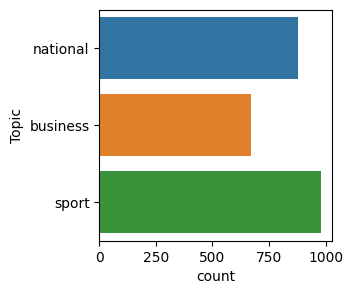

In [160]:
# plot the number of samples in 'HeadingOfNews'
plt.figure(figsize = (3, 3))
sns.countplot(y = "Topic", data = df)

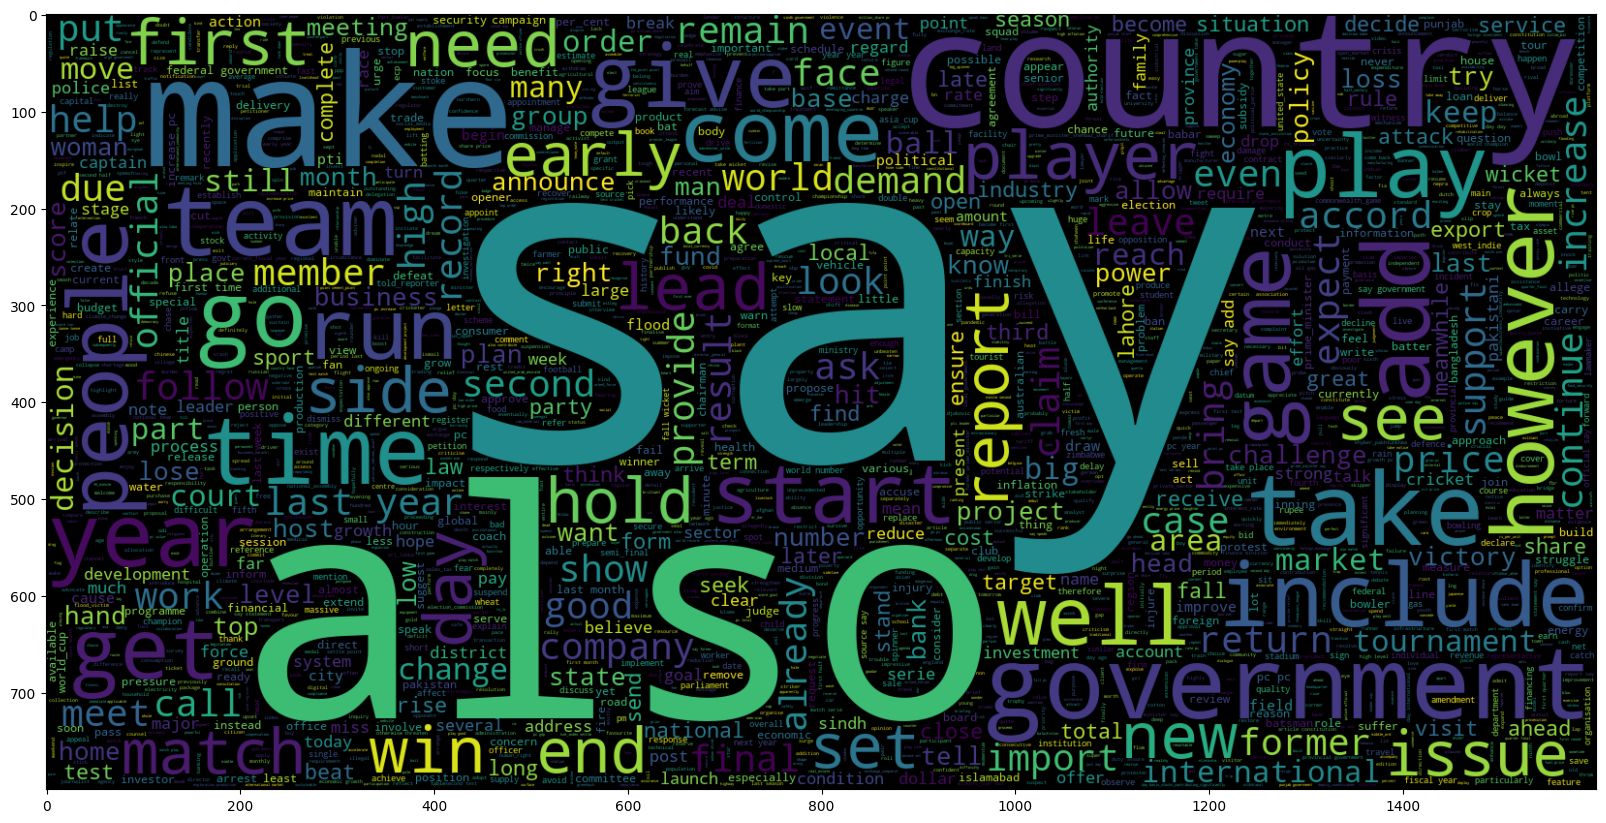

In [161]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df.clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [162]:
# length of maximum document will be needed to create word embeddings 
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 615


# FEATURE EMBEDDING USING BAG OF WORDS

In [163]:
id2word = corpora.Dictionary(data_lemmatized)

corpus = []
for text in data_lemmatized:
    new = id2word.doc2bow(text)
    corpus.append(new)

print ("BOW News1:\n",corpus[0])
# firstword = id2word[[0][:1][0]]
# print (firstword)


BOW News1:
 [(0, 4), (1, 2), (2, 1), (3, 1), (4, 1), (5, 2), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 7), (15, 1), (16, 2), (17, 1), (18, 3), (19, 2), (20, 1), (21, 4), (22, 1), (23, 6), (24, 1), (25, 1), (26, 2), (27, 5), (28, 3), (29, 2), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 3), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 6), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 2), (77, 3), (78, 1), (79, 1), (80, 1), (81, 2), (82, 2)]


# LDA TOPIC MODELLING

In [164]:
TOPIC_COUNT = 5

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=TOPIC_COUNT,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")


In [165]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=TOPIC_COUNT)
vis


/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/local/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.170498 -0.225253       1        1  32.819392
0     -0.038741  0.192623       2        1  26.866577
4     -0.120131 -0.199032       3        1  22.273547
2     -0.281961  0.063245       4        1   9.709669
1      0.270335  0.168418       5        1   8.330816, topic_info=            Term         Freq        Total Category  logprob  loglift
615           pc  2687.000000  2687.000000  Default   5.0000   5.0000
375        point  1523.000000  1523.000000  Default   4.0000   4.0000
69           say  8354.000000  8354.000000  Default   3.0000   3.0000
27    government  3112.000000  3112.000000  Default   2.0000   2.0000
589     increase  1349.000000  1349.000000  Default   1.0000   1.0000
...          ...          ...          ...      ...      ...      ...
4571     article   202.934918   209.009562   Topic5  -5.2371   2.4557
395        court   523.997812   654.726587   Topic5  -4.2885   2.2625
91          case   408.248438   739.711497   Topic5  -4.5381   1.8908
1503         law   335.647223   534.044777   Topic5  -4.7339   2.0208
721      account   337.081368   540.747801   Topic5  -4.7296   2.0126

[62 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
721       1  0.022191  account
721       2  0.349516  account
721       3  0.005548  account
721       5  0.623211  account
152       1  0.202649     also
...     ...       ...      ...
82        1  0.348732     year
82        2  0.561997     year
82        3  0.064880     year
82        4  0.000300     year
82        5  0.024030     year

[117 rows x 3 columns], R=5, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2])